# Deep Learning in Asset pricing

This notebook demonstrates an approach to asset pricing using a Generative Adversarial Network (GAN) framework, following [this paper](https://economics.yale.edu/sites/default/files/deep_learning_in_asset_pricing.pdf) of Chen, Pelger and Zhu. The aim is to estimate the Stochastic Discount Factor(SDF).

We use a Generative Adversarial Network to estimate the SDF by using the no-arbitrage condition:

$$E[M_t.R^e_{t,i}] = 0$$

where $M_t$ is the SDF and $R^e_{t,i}$ is the excess return (return over the risk free rate) of asset $i$ at time $t$.  



Our approach only differs from the paper in two ways:

1. The paper relies on large amount of data and requires computational resources. The paper uses 178 macro economic indicators to capture 'the state' of the economy and 46 firm specific characteristics as input data and stock data of around 10,000 stocks as test assets. To skip spending time on data cleaning and reduce computational load, we use 5 macro economic indicators and 5 Fama french factors + the risk free rate as our inputs. Our test assets will be the 25 Fama French portfolios.

2. The paper uses separate LSTM networks for Generator and Discriminator. We only use one single LSTM as a part of our Generator to capture the macro economic state and this will serve as inputs for a FeedForward Network in the generator and the discriminator




## 1. Installing Libraries

This section installs the necessary Python libraries for data fetching, manipulation, and model building.
- `getFamaFrenchFactors`: To download Fama-French factor data.
- `pandas_datareader`: To download macroeconomic data from FRED and Fama-French portfolio data.
- `lxml`: A dependency for `pandas_datareader`.
- `optuna`: For hyperparameter tuning.

In [1]:
!pip install -q getFamaFrenchFactors pandas_datareader lxml optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.8/247.8 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.6/607.6 kB 55.6 MB/s eta 0:00:00


## 2. Data Import and Preprocessing

This section handles the loading and initial processing of the  data.

### 2a. Importing Fama-French 5 factor data

We import the Fama-French 5 factors (Market-Risk Free, Small-Minus-Big, High-Minus-Low, Robust-Minus-Weak, Conservative-Minus-Aggressive) and the Risk-Free Rate.

In [28]:
import numpy as np
import pandas as pd
import getFamaFrenchFactors

print(dir(getFamaFrenchFactors))

['BeautifulSoup', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__warningregistry__', 'all_factor_links', 'all_factors_text', 'bold_tags', 'carhart4Factor', 'csv_links', 'factor_dict', 'famaFrench3Factor', 'famaFrench5Factor', 'ff3factor_dict', 'home_url', 'link', 'links_for_factor', 'momAndOthers_dict', 'momentumFactor', 'pd', 'relativedelta', 'requests', 'response', 'sib', 'soup', 'text', 'text_to_search', 'txt_links', 'url']


In [3]:
from getFamaFrenchFactors import famaFrench5Factor


# Get the factors
factors_df = famaFrench5Factor()

# Adjust from percentage
factors_df[['Mkt-RF', 'SMB', 'HML', 'RF']] = factors_df[['Mkt-RF', 'SMB', 'HML', 'RF']] / 100



In [4]:
factors_df.head(20)

,date_ff_factors,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07-31,-0.000039,-0.000048,-0.000081,0.0064,-0.0115,0.000027
1,1963-08-31,0.000508,-0.000080,0.000170,0.0040,-0.0038,0.000025
2,1963-09-30,-0.000157,-0.000043,0.000000,-0.0078,0.0015,0.000027
3,1963-10-31,0.000254,-0.000134,-0.000004,0.0279,-0.0225,0.000029
4,1963-11-30,-0.000086,-0.000085,0.000173,-0.0043,0.0227,0.000027
5,1963-12-31,0.000183,-0.000189,-0.000021,0.0012,-0.0025,0.000029
6,1964-01-31,0.000227,0.000010,0.000163,0.0021,0.0148,0.000030
7,1964-02-29,0.000155,0.000033,0.000281,0.0011,0.0081,0.000026
8,1964-03-31,0.000141,0.000141,0.000329,-0.0203,0.0298,0.000031
9,1964-04-30,0.000011,-0.000148,-0.000054,-0.0132,-0.0113,0.000029


We adjust the start date to -1-31-1964

In [5]:
FFdata = factors_df.iloc[6:]
FFdata['date_ff_factors'] = pd.to_datetime(FFdata['date_ff_factors'])
FFdata = FFdata.set_index('date_ff_factors')

/tmp/ipython-input-4197135584.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FFdata['date_ff_factors'] = pd.to_datetime(FFdata['date_ff_factors'])


### 2b. Importing the macroeconomic data

Macroeconomic indicators are fetched from the FRED database. The selected indicators include measures of the term spread, default spread, industrial production, unemployment rate, and consumer sentiment.

In [6]:
import pandas_datareader.data as web

# --- 1. Define the 5 Long-History Macro Indicators (FRED Tickers) ---
long_macro_tickers = {
    'Term_Spread': 'T10YFFM',      # 10-Yr Yield minus Fed Funds Rate
    'Default_Spread': 'AAAFFM',     # Baa Corp Yield minus Aaa Corp Yield (Risk Aversion Proxy)
    'Ind_Production': 'INDPRO',     # Industrial Production Index
    'Unemployment': 'UNRATE',       # Civilian Unemployment Rate
    'Consumer_Sentiment': 'UMCSENT' # University of Michigan Consumer Sentiment
}

# --- 2. Define the Time Period
start_date = '1964-01-01'
end_date = '2025-08-31'

# --- 3. Fetch Data from FRED ---
try:
    macro_data = web.DataReader(
        list(long_macro_tickers.values()),
        'fred',
        start=start_date,
        end=end_date
    )
    macro_data.columns = list(long_macro_tickers.keys())

except Exception as e:
    print(f"Error fetching data from FRED: {e}")
    macro_data = pd.DataFrame(index=pd.date_range(start_date, end_date, freq='M'))

# --- 4. Align Data to Monthly Frequency ---

# 4a. Forward-Fill any monthly gaps (common in macro data)
macro_data = macro_data.ffill()

# 4b. Ensure all data points are at the end of the month for clean alignment
macro_data = macro_data.resample('ME').last()


# --- 5. Display the result ---
print(f"Macro Data Imported and Aligned ({len(macro_data)} periods, starting {macro_data.index.min().strftime('%Y-%m')}):")
print(macro_data.head())
print("\n... and the tail:")
print(macro_data.tail())

# The resulting 'macro_data' DataFrame is ready for merging with Fama-French data.

Macro Data Imported and Aligned (740 periods, starting 1964-01):
            Term_Spread  Default_Spread  Ind_Production  Unemployment  \
DATE                                                                    
1964-01-31         0.69            0.91         27.7409           5.6   
1964-02-29         0.67            0.88         27.9291           5.4   
1964-03-31         0.79            0.95         27.9291           5.4   
1964-04-30         0.76            0.93         28.3861           5.3   
1964-05-31         0.70            0.91         28.5474           5.1   

            Consumer_Sentiment  
DATE                            
1964-01-31                 NaN  
1964-02-29                99.5  
1964-03-31                99.5  
1964-04-30                99.5  
1964-05-31                98.5  

... and the tail:
            Term_Spread  Default_Spread  Ind_Production  Unemployment  \
DATE                                                                    
2025-04-30        -0.05    

In [7]:
print(macro_data.shape, FFdata.shape)

(740, 5) (740, 6)


### 2c. Importing the FF-portfolios

The Fama-French 25 portfolios sorted by size and book-to-market are imported. These portfolios serve as the test assets that the learned SDF will attempt to price.

In [8]:
# --- 1. Define Time Period ---
# Must match the start date used for your FF factors and macro data (e.g., 1964-01-01)
start_date = '1964-01-01'
end_date = '2025-08-31'

# --- 2. Fetch the 25 Portfolios (Size x Book-to-Market) ---
# The data is downloaded as a dictionary object
ff_portfolio = web.DataReader(
    '25_Portfolios_5x5',
    'famafrench',
    start=start_date,
    end=end_date
)

df_returns_25 = ff_portfolio[0]

df_returns_25 = df_returns_25.replace([-99.99, -999], np.nan) # Missing values are indicated by -99.99 or -999
df_returns_25.dropna(inplace=True)

df_returns_25 = (df_returns_25/100)# Converting from percentage to fraction

# Convert PeriodIndex to DatetimeIndex at the end of the month
df_returns_25.index = df_returns_25.index.to_timestamp(how = 'end').date




/tmp/ipython-input-3312524815.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_portfolio = web.DataReader(
/tmp/ipython-input-3312524815.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_portfolio = web.DataReader(
/tmp/ipython-input-3312524815.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_portfolio = web.DataReader(
/tmp/ipython-input-3312524815.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'obje

### 2d. Combining all the data into a DataFrame


In [10]:
# Making the index into a datetime object
macro_data.index = pd.to_datetime(macro_data.index)


# Combine the dataframes using merge on the index

combined_data_FF_macro = pd.merge(FFdata, macro_data, left_index=True, right_index=True, how='inner') # Combining FF and Macro. Dropping first row because of a null value

combined_data = pd.merge(combined_data_FF_macro, df_returns_25, left_index=True, right_index=True, how='inner')

combined_data.dropna(inplace=True) # Dropping NaN entries

# Display the combined data
print("Combined Data:")
display(combined_data.head())
print("\n... and the tail:")
display(combined_data.tail())

Combined Data:


,Mkt-RF,SMB,HML,RMW,CMA,RF,Term_Spread,Default_Spread,Ind_Production,Unemployment,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
date_ff_factors,,,,,,,,,,,,,,,,,,,,,
1964-02-29,0.000155,0.000033,0.000281,0.0011,0.0081,0.000026,0.67,0.88,27.9291,5.4,...,0.025943,0.015619,0.028444,0.072047,0.046121,0.018271,0.005232,0.010194,0.039989,0.037567
1964-03-31,0.000141,0.000141,0.000329,-0.0203,0.0298,0.000031,0.79,0.95,27.9291,5.4,...,0.017750,0.029767,0.052497,0.071287,0.007247,0.011575,0.007635,0.036237,0.038382,0.001491
1964-04-30,0.000011,-0.000148,-0.000054,-0.0132,-0.0113,0.000029,0.76,0.93,28.3861,5.3,...,-0.027045,0.003434,0.019784,-0.026384,-0.022805,0.002272,0.014745,0.008082,-0.009054,0.024147
1964-05-31,0.000141,-0.000062,0.000181,-0.0015,0.0013,0.000026,0.70,0.91,28.5474,5.1,...,0.011914,0.022992,0.013559,0.013281,0.040990,0.020599,0.003304,0.011776,0.042859,0.033968
1964-06-30,0.000127,0.000013,0.000068,-0.0033,0.0010,0.000030,0.67,0.91,28.6280,5.2,...,0.010927,0.014771,0.011035,0.024965,0.031119,0.009744,0.028644,0.004437,0.013682,0.024217



... and the tail:


,Mkt-RF,SMB,HML,RMW,CMA,RF,Term_Spread,Default_Spread,Ind_Production,Unemployment,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
date_ff_factors,,,,,,,,,,,,,,,,,,,,,
2025-04-30,-0.000084,-0.000186,-0.000340,-0.0285,-0.0267,0.000035,-0.05,1.12,103.6224,4.2,...,-0.008766,-0.012699,-0.020146,-0.039276,-0.072668,0.014106,-0.030129,-0.073867,-0.013472,-0.027941
2025-05-31,0.000606,-0.000072,-0.000288,0.0126,0.0251,0.000038,0.09,1.21,103.6570,4.2,...,0.062577,0.050222,0.035353,0.081175,0.065826,0.078077,0.061296,0.018407,0.026156,0.065684
2025-06-30,0.000486,-0.000002,-0.000160,-0.0319,0.0145,0.000034,0.05,1.13,104.2115,4.1,...,0.020351,0.043192,0.024175,0.073815,0.058024,0.055279,0.062451,0.047405,0.036424,0.070109
2025-07-31,0.000198,-0.000015,-0.000127,-0.0029,-0.0207,0.000034,0.06,1.12,103.8194,4.2,...,0.034206,0.021766,0.009013,-0.001069,-0.019303,0.032949,0.014068,0.012224,0.002333,-0.013744
2025-08-31,0.000185,0.000488,0.000441,-0.0069,0.0207,0.000038,-0.07,1.02,103.9203,4.3,...,0.036524,0.016164,0.023481,0.058848,0.071342,0.011610,0.011927,0.030567,0.054257,0.090799


In [11]:
combined_data.columns

Index(['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'Term_Spread',
       'Default_Spread', 'Ind_Production', 'Unemployment',
       'Consumer_Sentiment', 'SMALL LoBM', 'ME1 BM2', 'ME1 BM3', 'ME1 BM4',
       'SMALL HiBM', 'ME2 BM1', 'ME2 BM2', 'ME2 BM3', 'ME2 BM4', 'ME2 BM5',
       'ME3 BM1', 'ME3 BM2', 'ME3 BM3', 'ME3 BM4', 'ME3 BM5', 'ME4 BM1',
       'ME4 BM2', 'ME4 BM3', 'ME4 BM4', 'ME4 BM5', 'BIG LoBM', 'ME5 BM2',
       'ME5 BM3', 'ME5 BM4', 'BIG HiBM'],
      dtype='object')

In [12]:
FF_columns = combined_data.columns[:6]
macro_columns = combined_data.columns[6:11]
portfolio_columns = combined_data.columns[11:]

no_of_FF_features = len(FF_columns)
no_macro_features = len(macro_columns)
no_of_portfolios = len(portfolio_columns)




### 2e. Data Scaling

We use `StandardScaler` to scale the data to have zero mean and unit variance.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


processed_data = scaler.fit_transform(combined_data)
processed_data[:5]

processed_data.shape


(739, 36)

### 2f. Creating rolling windows for LSTM input

A `rolling_window` function is defined to create sequential data for the LSTM layer in the Generator network. Macroeconomic data is processed into 12-month lookback windows. The Fama-French factors and portfolio returns are aligned with the end of these windows.

In [14]:
# Function to create rolling windows on a timeseries data

def rolling_window(data, lookback):
  x_rolling = []
  for i in range(len(data) - lookback):
    x_rolling.append(data[i: i + lookback])

  return np.array(x_rolling)

lookback = 12
ff_data = processed_data[:, :no_of_FF_features]
macro_data = processed_data[:, no_of_FF_features: no_of_FF_features + no_macro_features]
portfolio_data = processed_data[:, no_of_FF_features + no_macro_features:]

# Creating rolling window on macro data
X_macro_rolled = rolling_window(macro_data, lookback)[:-1]

# Aligning the rolling data with FF factor and Portfolio data
X_ff_aligned = ff_data[lookback-1: -1 ]
Y_targets_aligned = portfolio_data[lookback:]




### 2g. Creating Dataset and DataLoaders

Standard PyTorch process for batch creation and data loading

In [15]:
# Creating Dataset

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset # Import Subset

class AssetPricingDataset(Dataset):

    def __init__(self, macro_data, ff_data, target_data):
        # 1. Convert all data to PyTorch tensors
        #    We use .float() for all data as they are continuous variables.
        self.X_macro = torch.tensor(macro_data).float()
        self.X_ff = torch.tensor(ff_data).float()
        self.Y_targets = torch.tensor(target_data).float()

    def __len__(self):
        return len(self.X_macro)

    def __getitem__(self, idx):
        return {
            'macro_X': self.X_macro[idx],    # Shape: [12, 5]
            'ff_X': self.X_ff[idx],          # Shape: [6]
            'target_Y': self.Y_targets[idx]  # Shape: [25]
        }

data = AssetPricingDataset(X_macro_rolled, X_ff_aligned, Y_targets_aligned)
no_of_samples = len(data)
train_size = int(len(data)*0.8)
val_size = int(len(data)*0.1)


# Use Subset to create train and test datasets
indices = list(range(no_of_samples))
train_indices = indices[:train_size]
val_indices = indices[train_size: train_size+val_size]
test_indices = indices[train_size+val_size:]

train_data = Subset(data, train_indices)
val_data = Subset(data, val_indices)
test_data = Subset(data, test_indices)


BATCH_SIZE = 64

train_dataset = DataLoader(dataset = train_data, batch_size=BATCH_SIZE, shuffle = True, drop_last = True)
val_dataset = DataLoader(dataset = val_data, batch_size=BATCH_SIZE, shuffle = True, drop_last = True)
test_dataset = DataLoader(dataset = test_data, batch_size=BATCH_SIZE, shuffle = False, drop_last = False)

# Model Architecture

This section defines the architecture of the Generator and Discriminator networks within the GAN framework.

## Generator (SDF Network)

The Generator takes macroeconomic time series (processed by an LSTM) and Fama-French factors as input. It outputs portfolio weights that define the Stochastic Discount Factor (SDF). The SDF is constructed as $M = 1 - \omega R$, where $\omega$ are the predicted weights and $R$ are the asset returns.

## Discriminator (Conditioning Network)

The Discriminator takes the hidden state from the Generator's LSTM and the Fama-French factors as input. It outputs conditioning instruments ($g$) used in the no-arbitrage pricing condition. The no-arbitrage condition states that the expected value of the product of the SDF and any asset return, conditional on information $g$, is zero: $E[R_i M | g] = 0$.

In [16]:
class Generator(nn.Module):
    """
    Generator (SDF Network)

    Inputs:
    - macro_X: Macro time series [batch, seq_len, macro_dim]
    - ff_X: Fama-French factors [batch, ff_dim]

    Output:
    - omega: SDF portfolio weights [batch, num_assets]
    - h_t: Hidden macro states [batch, hidden_dim]
    """
    def __init__(self, macro_dim, ff_dim, hidden_dim, lstm_layers, num_assets):
        super().__init__()

        # LSTM for processing macro time series
        self.lstm = nn.LSTM(
            input_size=macro_dim,
            hidden_size=macro_dim,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=0.05 if lstm_layers > 1 else 0
        )

        # Feedforward network: [hidden_states + FF_factors] -> portfolio_weights
        self.fc1 = nn.Linear(macro_dim + ff_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)

        # Output layer: portfolio weights for each asset
        self.fc3 = nn.Linear(hidden_dim//2, num_assets)

        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.05)

    def forward(self, macro_X, ff_X):
        # Process macro time series with LSTM
        _, (h_n, c_n) = self.lstm(macro_X)
        h_t = h_n[-1]  # Take last hidden state

        # Combine macro states with FF factors
        combined = torch.cat([h_t, ff_X], dim=1)

        # Feedforward layers
        x = self.fc1(combined)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.dropout(x)

        # Output: portfolio weights
        omega = self.fc3(x)

        return omega, h_t


class Discriminator(nn.Module):
    """
    Discriminator (Conditioning Network)

    Inputs:
    - h_t: Hidden macro states [batch, hidden_dim]
    - ff_X: FF factors [batch, ff_dim]

    Output:
    - g: Conditioning instruments [batch, num_instruments]
    """
    def __init__(self, hidden_dim, ff_dim, num_instruments, hidden_layer):
        super().__init__()

        input_dim = hidden_dim + ff_dim

        self.fc1 = nn.Linear(input_dim, hidden_layer)
        self.bn1 = nn.BatchNorm1d(hidden_layer)
        self.fc2 = nn.Linear(hidden_layer, hidden_layer // 2)
        self.bn2 = nn.BatchNorm1d(hidden_layer // 2)
        self.fc3 = nn.Linear(hidden_layer // 2, num_instruments)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.05)

    def forward(self, h_t, ff_X):
        # Combine macro states with FF factors
        x = torch.cat([h_t, ff_X], dim=1)

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.dropout(x)

        # Output: conditioning instruments
        g = torch.tanh(self.fc3(x))  # Bounded in [-1, 1]

        return g

# Loss Function

This section defines the loss functions used to train the Generator and Discriminator networks.

- `calculate_SDF`: Computes the Stochastic Discount Factor given portfolio weights and returns.
- `no_arbitrage_loss`: Calculates the pricing errors based on the no-arbitrage condition $E[R_i M g] = 0$. The loss is the mean squared pricing error.
- `discriminator_loss`: The loss function for the Discriminator, which aims to maximize the no-arbitrage loss plus a regularization term.
- `generator_loss`: The loss function for the Generator, which aims to minimize the no-arbitrage loss plus a regularization term on the weights.

In [17]:
# Loss function

def calculate_SDF(weights, returns):

  weighted_returns = (weights*returns).sum(dim=1, keepdim=True)
  sdf_m = 1 - weighted_returns

  return sdf_m

def no_arbitrage_loss(weights, returns, g_instruments, num_assets):

  sdf = calculate_SDF(weights, returns)
  g_expanded = g_instruments.mean(dim=1, keepdim=True).expand(-1, num_assets)
  pricing_errors = sdf*returns*g_expanded
  mean_errors = pricing_errors.mean(dim = 0)
  loss = (mean_errors**2).mean()
  return loss


def discriminator_loss(weights, returns, g_instruments, num_assets):

  na_loss = no_arbitrage_loss(weights, returns, g_instruments, num_assets)
  D_regularization_term = 0.01*(g_instruments**2).mean()

  return -na_loss + D_regularization_term

def generator_loss(weights, returns, g_instruments, num_assets):

  na_loss = no_arbitrage_loss(weights, returns, g_instruments, num_assets)
  G_regularization_term = 0.01*(weights**2).mean()

  return na_loss + G_regularization_term



# Model Training

This section implements the training loop for the GAN. The Discriminator is trained to maximize the no-arbitrage loss, while the Generator is trained to minimize it. The training process alternates between updating the Discriminator and the Generator.

In [18]:
import torch.optim as optim
# training loop

def training(generator, discriminator, train_loader, epochs, d_lr, g_lr):
  D_optim = optim.Adam(discriminator.parameters(), lr = d_lr)
  G_optim = optim.Adam(generator.parameters(), lr = g_lr)

  d_losses = []
  g_losses = []

  generator.train()
  discriminator.train()

  for epoch in range(epochs):
    epoch_g_loss = 0
    epoch_d_loss = 0
    num_batches = 0

    for batch in train_loader:
      macro_X = batch['macro_X']
      ff_X = batch['ff_X']
      returns = batch['target_Y']

    # Training the discriminator (trained twice)
      for i in range(2):
        D_optim.zero_grad()

        # Generate SDF weights
        weights, h_t = generator(macro_X, ff_X)

        # Generate conditioning instruments
        g_inst = discriminator(h_t.detach(), ff_X)

        # Compute discriminator loss (weights are detached to above updating generator weights)
        d_loss = discriminator_loss(weights.detach(), returns, g_inst, no_of_portfolios)

        # Backprop on discriminator
        d_loss.backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
        D_optim.step()


    # Training the generator
      G_optim.zero_grad()
    # Generate SDF weights
      weights, h_t = generator(macro_X, ff_X)

    # Conditioning instruments
      g_inst = discriminator(h_t.detach(), ff_X)
    # Computer generator loss
      g_loss = generator_loss(weights, returns, g_inst.detach(), no_of_portfolios)
    # Backprop on generator
      g_loss.backward()
      torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
      G_optim.step()

      epoch_g_loss += g_loss.item()
      epoch_d_loss += d_loss.item()
      num_batches += 1

    # Average losses in an epoch

    avg_g_loss = epoch_g_loss / num_batches
    avg_d_loss = epoch_d_loss / num_batches

    g_losses.append(avg_g_loss)
    d_losses.append(avg_d_loss)

    # Moniter the loss
    if (epoch + 1) % 50 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], G Loss: {avg_g_loss:.6f}, D Loss: {avg_d_loss:.6f}')

  return g_losses, d_losses



# Baseline Models

This section defines baseline models for comparison with the GAN.

## 1. Fama-French linear model

This baseline estimates the traditional Fama-French 5-factor model for each portfolio and calculates metrics like Sharpe Ratio and average absolute alpha.



In [19]:
from sklearn.linear_model import LinearRegression

def baseline_fama_french_5(train_loader, test_loader):
    """
    Baseline 1: Fama-French 5-Factor Model

    Traditional factor model:
    R_i,t = α_i + β'·F_t + ε_i,t
    """
    print("\n" + "="*60)
    print("BASELINE 1: Fama-French 5-Factor Model")
    print("="*60)

    # Collect all data
    train_returns = []
    train_ff = []
    test_returns = []
    test_ff = []

    for batch in train_loader:
        train_returns.append(batch['target_Y'].numpy())
        train_ff.append(batch['ff_X'].numpy())

    for batch in test_loader:
        test_returns.append(batch['target_Y'].numpy())
        test_ff.append(batch['ff_X'].numpy())

    train_returns = np.concatenate(train_returns, axis=0)
    train_ff = np.concatenate(train_ff, axis=0)
    test_returns = np.concatenate(test_returns, axis=0)
    test_ff = np.concatenate(test_ff, axis=0)

    # Use first 5 FF factors (excluding RF)
    train_ff = train_ff[:, :5]  # Mkt-RF, SMB, HML, RMW, CMA
    test_ff = test_ff[:, :5]

    # Estimate factor loadings for each portfolio
    betas = []
    alphas = []

    for i in range(train_returns.shape[1]):
        model = LinearRegression()
        model.fit(train_ff, train_returns[:, i])
        betas.append(model.coef_)
        alphas.append(model.intercept_)

    betas = np.array(betas)
    alphas = np.array(alphas)

    # Create SDF = mean-variance efficient combination of factors
    mean_factors = train_ff.mean(axis=0)
    cov_factors = np.cov(train_ff.T)

    try:
        weights = np.linalg.solve(cov_factors, mean_factors)
        train_sdf_returns = (train_ff @ weights).flatten()
        test_sdf_returns = (test_ff @ weights).flatten()
    except:
        # If singular, use equal weights
        train_sdf_returns = train_ff.mean(axis=1)
        test_sdf_returns = test_ff.mean(axis=1)

    # Compute metrics
    train_sharpe = (train_sdf_returns.mean() / train_sdf_returns.std()) * np.sqrt(12)
    test_sharpe = (test_sdf_returns.mean() / test_sdf_returns.std()) * np.sqrt(12)
    avg_alpha = np.abs(alphas).mean()

    print(f"Train Sharpe Ratio: {train_sharpe:.4f}")
    print(f"Test Sharpe Ratio: {test_sharpe:.4f}")
    print(f"Average |Alpha|: {avg_alpha:.6f}")

    return {
        'train_sharpe': train_sharpe,
        'test_sharpe': test_sharpe,
        'avg_alpha': avg_alpha,
        'train_returns': train_sdf_returns,
        'test_returns': test_sdf_returns
    }

## 2. Mean-Variance portfolio

This baseline constructs a simple mean-variance efficient portfolio based on the historical mean and covariance of the portfolio returns in the training data.

In [20]:
def baseline_linear_mv(train_loader, test_loader):
    """
    Baseline 2: Simple Linear Mean-Variance Portfolio

    Maximize: ω'μ - λ·ω'Σω
    """
    print("\n" + "="*60)
    print("BASELINE 2: Linear Mean-Variance Portfolio")
    print("="*60)

    # Collect returns
    train_returns = []
    test_returns = []

    for batch in train_loader:
        train_returns.append(batch['target_Y'].numpy())

    for batch in test_loader:
        test_returns.append(batch['target_Y'].numpy())

    train_returns = np.concatenate(train_returns, axis=0)
    test_returns = np.concatenate(test_returns, axis=0)

    # Estimate mean and covariance
    mean_ret = train_returns.mean(axis=0)
    cov_mat = np.cov(train_returns.T)

    # Solve for tangency portfolio
    try:
        inv_cov = np.linalg.inv(cov_mat)
        weights = inv_cov @ mean_ret
        weights = weights / np.abs(weights).sum()
    except:
        weights = np.ones(train_returns.shape[1]) / train_returns.shape[1]

    # Portfolio returns
    train_portfolio_ret = (train_returns @ weights).flatten()
    test_portfolio_ret = (test_returns @ weights).flatten()

    # Compute Sharpe ratios
    train_sharpe = (train_portfolio_ret.mean() / train_portfolio_ret.std()) * np.sqrt(12)
    test_sharpe = (test_portfolio_ret.mean() / test_portfolio_ret.std()) * np.sqrt(12)

    print(f"Train Sharpe Ratio: {train_sharpe:.4f}")
    print(f"Test Sharpe Ratio: {test_sharpe:.4f}")
    print(f"Portfolio weights range: [{weights.min():.4f}, {weights.max():.4f}]")

    return {
        'train_sharpe': train_sharpe,
        'test_sharpe': test_sharpe,
        'weights': weights,
        'train_returns': train_portfolio_ret,
        'test_returns': test_portfolio_ret
    }


# Evaluation

This section defines metrics and evaluates the performance of the trained models.

## 1. Evaluation metrics

The `evaluate_GAN` function calculates several metrics for the GAN model on a given dataset:
- Sharpe Ratio: Measures the risk-adjusted return of the portfolio implied by the SDF weights.
- Cross-sectional R²: Measures how well the model-implied expected returns explain the variation in average realized returns across portfolios.
- Mean Absolute Pricing Error, Max Pricing Error, Mean Squared Pricing Error: Measure the magnitude of the deviations from the no-arbitrage condition.



In [21]:
def evaluate_GAN(generator, test_loader):

    generator.eval()
    all_sdf = []
    all_returns = []
    all_predictions = []

    with torch.no_grad():
        for batch in test_loader:
            macro = batch['macro_X']
            char = batch['ff_X']
            returns = batch['target_Y']

            # Get SDF weights
            sdf_weights, _ = generator(macro, char)

            # Construct SDF
            sdf = 1 - (sdf_weights * returns).sum(dim=1)

            all_sdf.append(sdf.numpy())
            all_returns.append(returns.numpy())
            all_predictions.append(sdf_weights.numpy())

    sdf = np.concatenate(all_sdf)
    returns = np.concatenate(all_returns)
    predictions = np.concatenate(all_predictions)

    # Compute metrics
    results = {}

    # 1. Sharpe Ratio
    portfolio_returns = (predictions * returns).sum(axis=1)
    results['sharpe_ratio'] = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(12)

    # 2. Cross-sectional R²
    mean_returns = returns.mean(axis=0)
    pred_returns = predictions.mean(axis=0) @ mean_returns
    results['cross_sectional_r2'] = 1 - np.sum((mean_returns - pred_returns)**2) / np.sum((mean_returns - mean_returns.mean())**2)

    # 3. Pricing errors
    pricing_errors = (sdf.reshape(-1, 1) * returns).mean(axis=0)
    results['mean_abs_pricing_error'] = np.abs(pricing_errors).mean()
    results['max_pricing_error'] = np.abs(pricing_errors).max()
    results['mean_squared_pricing_error'] = (pricing_errors**2).mean()

    return results

## 2. Model training and Evaluation

This section trains the GAN model and evaluates its performance on the training, validation, and test datasets using the defined metrics. It also evaluates the baseline models for comparison.

Epoch [50/250], G Loss: 0.006215, D Loss: -0.004088
Epoch [100/250], G Loss: 0.015280, D Loss: -0.003806
Epoch [150/250], G Loss: 0.027167, D Loss: -0.010779
Epoch [200/250], G Loss: 0.013256, D Loss: -0.010846
Epoch [250/250], G Loss: 0.025013, D Loss: -0.024445


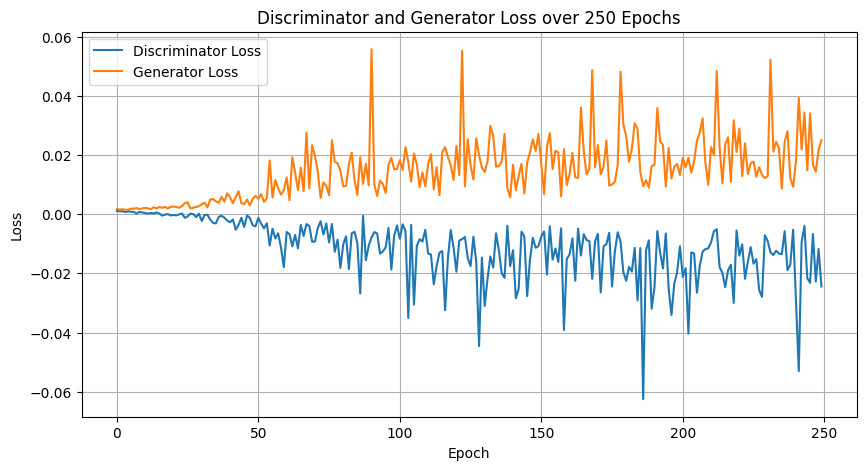

Train Sharpe Ratio: 0.0398
Train Cross-sectional R²: -4.2115
Train Mean Absolute Pricing Error: 0.088707
Train Max Pricing Error: 0.113787
Train Mean Squared Pricing Error: 0.008145
Validation Sharpe Ratio: 0.2065
Cross-sectional R²: -0.2899
Mean Absolute Pricing Error: 0.070652
Max Pricing Error: 0.136145
Mean Squared Pricing Error: 0.006226
Test Sharpe Ratio: -0.4352
Cross-sectional R²: -8.6164
Mean Absolute Pricing Error: 0.085369
Max Pricing Error: 0.525502
Mean Squared Pricing Error: 0.017366
Epoch [50/500], G Loss: 0.004874, D Loss: -0.003077
Epoch [100/500], G Loss: 0.005656, D Loss: -0.003090
Epoch [150/500], G Loss: 0.007110, D Loss: -0.005624
Epoch [200/500], G Loss: 0.006830, D Loss: -0.010377
Epoch [250/500], G Loss: 0.007172, D Loss: -0.002463
Epoch [300/500], G Loss: 0.015987, D Loss: -0.014439
Epoch [350/500], G Loss: 0.005854, D Loss: -0.003282
Epoch [400/500], G Loss: 0.008489, D Loss: -0.006501
Epoch [450/500], G Loss: 0.005653, D Loss: -0.003108
Epoch [500/500], G Lo

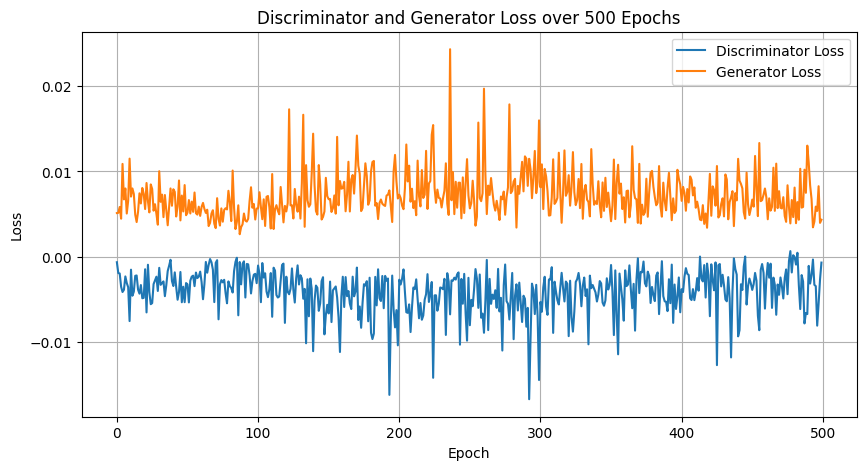

Train Sharpe Ratio: 0.2134
Train Cross-sectional R²: -1.1700
Train Mean Absolute Pricing Error: 0.113439
Train Max Pricing Error: 0.166515
Train Mean Squared Pricing Error: 0.014151
Validation Sharpe Ratio: 1.2642
Cross-sectional R²: -2.3816
Mean Absolute Pricing Error: 0.044531
Max Pricing Error: 0.113826
Mean Squared Pricing Error: 0.002772
Test Sharpe Ratio: -0.2071
Cross-sectional R²: -1.6584
Mean Absolute Pricing Error: 0.246462
Max Pricing Error: 0.574554
Mean Squared Pricing Error: 0.067734
Epoch [50/1500], G Loss: 0.005595, D Loss: -0.001178
Epoch [100/1500], G Loss: 0.008076, D Loss: -0.001001
Epoch [150/1500], G Loss: 0.013408, D Loss: -0.004453
Epoch [200/1500], G Loss: 0.018096, D Loss: -0.010604
Epoch [250/1500], G Loss: 0.013568, D Loss: -0.009178
Epoch [300/1500], G Loss: 0.018535, D Loss: -0.043081
Epoch [350/1500], G Loss: 0.020307, D Loss: -0.009981
Epoch [400/1500], G Loss: 0.021541, D Loss: -0.003628
Epoch [450/1500], G Loss: 0.022829, D Loss: -0.001559
Epoch [500/1

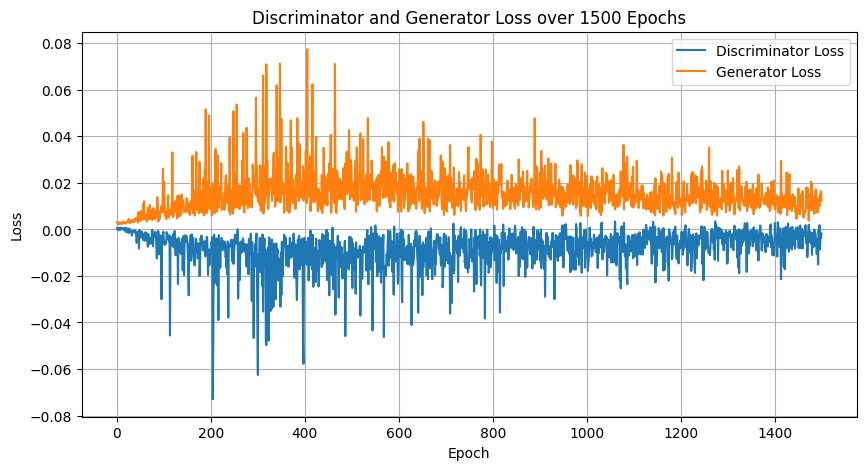

Train Sharpe Ratio: 0.5957
Train Cross-sectional R²: -0.1267
Train Mean Absolute Pricing Error: 0.019839
Train Max Pricing Error: 0.048887
Train Mean Squared Pricing Error: 0.000569
Validation Sharpe Ratio: -0.3613
Cross-sectional R²: -0.0003
Mean Absolute Pricing Error: 0.084192
Max Pricing Error: 0.283979
Mean Squared Pricing Error: 0.010914
Test Sharpe Ratio: -0.1994
Cross-sectional R²: -0.7729
Mean Absolute Pricing Error: 0.378229
Max Pricing Error: 0.720386
Mean Squared Pricing Error: 0.156407
Epoch [50/2000], G Loss: 0.013279, D Loss: -0.003806
Epoch [100/2000], G Loss: 0.012218, D Loss: -0.006875
Epoch [150/2000], G Loss: 0.007350, D Loss: -0.007863
Epoch [200/2000], G Loss: 0.018057, D Loss: -0.013246
Epoch [250/2000], G Loss: 0.011321, D Loss: -0.006449
Epoch [300/2000], G Loss: 0.012360, D Loss: -0.009255
Epoch [350/2000], G Loss: 0.010682, D Loss: -0.004582
Epoch [400/2000], G Loss: 0.009522, D Loss: -0.002129
Epoch [450/2000], G Loss: 0.015269, D Loss: -0.011358
Epoch [500/

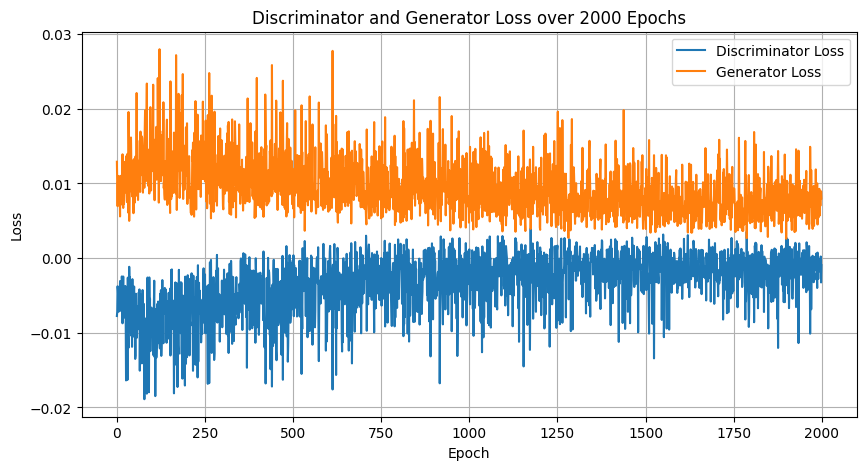

Train Sharpe Ratio: 1.1360
Train Cross-sectional R²: -0.0045
Train Mean Absolute Pricing Error: 0.032750
Train Max Pricing Error: 0.062327
Train Mean Squared Pricing Error: 0.001326
Validation Sharpe Ratio: -0.1319
Cross-sectional R²: -0.7910
Mean Absolute Pricing Error: 0.046050
Max Pricing Error: 0.132724
Mean Squared Pricing Error: 0.003264
Test Sharpe Ratio: 0.2630
Cross-sectional R²: -0.0257
Mean Absolute Pricing Error: 0.217761
Max Pricing Error: 0.362128
Mean Squared Pricing Error: 0.050715


In [40]:
# Checking the stabilization of training loss vs no of epoch
import matplotlib.pyplot as plt

macro_dim = no_macro_features
ff_dim = no_of_FF_features
num_assets = no_of_portfolios

# Hyperparameters
hidden_dim = 16
lstm_layers = 2
hidden_layer = 16
epochs = [250,500,1500,2000]
d_lr = 1e-4
g_lr = 1e-4

for epoch in epochs:

  generator = Generator(macro_dim, ff_dim, hidden_dim, lstm_layers, num_assets)

  discriminator =  Discriminator(macro_dim, ff_dim, num_assets, hidden_layer)

  g_losses, d_losses = training(generator, discriminator, train_dataset, epoch, d_lr, g_lr)

  plt.figure(figsize=(10, 5))
  plt.plot(range(epoch), d_losses, label='Discriminator Loss')
  plt.plot(range(epoch), g_losses, label='Generator Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'Discriminator and Generator Loss over {epoch} Epochs')
  plt.legend()
  plt.grid(True)
  plt.show()

  Gan_train = evaluate_GAN(generator, train_dataset)

  print(f"Train Sharpe Ratio: {Gan_train['sharpe_ratio']:.4f}")
  print(f"Train Cross-sectional R²: {Gan_train['cross_sectional_r2']:.4f}")
  print(f"Train Mean Absolute Pricing Error: {Gan_train['mean_abs_pricing_error']:.6f}")
  print(f"Train Max Pricing Error: {Gan_train['max_pricing_error']:.6f}")
  print(f"Train Mean Squared Pricing Error: {Gan_train['mean_squared_pricing_error']:.6f}")

  Gan_val = evaluate_GAN(generator, val_dataset)

  print(f"Validation Sharpe Ratio: {Gan_val['sharpe_ratio']:.4f}")
  print(f"Cross-sectional R²: {Gan_val['cross_sectional_r2']:.4f}")
  print(f"Mean Absolute Pricing Error: {Gan_val['mean_abs_pricing_error']:.6f}")
  print(f"Max Pricing Error: {Gan_val['max_pricing_error']:.6f}")
  print(f"Mean Squared Pricing Error: {Gan_val['mean_squared_pricing_error']:.6f}")

  Gan_test = evaluate_GAN(generator, test_dataset)

  print(f"Test Sharpe Ratio: {Gan_test['sharpe_ratio']:.4f}")
  print(f"Cross-sectional R²: {Gan_test['cross_sectional_r2']:.4f}")
  print(f"Mean Absolute Pricing Error: {Gan_test['mean_abs_pricing_error']:.6f}")
  print(f"Max Pricing Error: {Gan_test['max_pricing_error']:.6f}")
  print(f"Mean Squared Pricing Error: {Gan_test['mean_squared_pricing_error']:.6f}")





In [23]:

train_sharpe_list = []
test_sharpe_list = []
val_sharpe_list = []

epoch = 1000
d_lr = 1e-4
g_lr = 1e-4
macro_dim = no_macro_features
ff_dim = no_of_FF_features
num_assets = no_of_portfolios

# Hyperparameters
hidden_dim = 16
lstm_layers = 2
hidden_layer = 16

for i in range(5):
  generator = Generator(macro_dim, ff_dim, hidden_dim, lstm_layers, num_assets)

  discriminator =  Discriminator(macro_dim, ff_dim, num_assets, hidden_layer)

  g_losses, d_losses = training(generator, discriminator, train_dataset, epoch, d_lr, g_lr)

  Gan_train = evaluate_GAN(generator, train_dataset)

  train_sharpe_list.append(Gan_train['sharpe_ratio'])

  Gan_val = evaluate_GAN(generator, val_dataset)

  val_sharpe_list.append(Gan_val['sharpe_ratio'])

  Gan_test = evaluate_GAN(generator, test_dataset)

  test_sharpe_list.append(Gan_test['sharpe_ratio'])

plt.figure(figsize=(10, 5))
plt.plot(range(10), train_sharpe_list, label='Train Sharpe Ratio')
plt.plot(range(10), val_sharpe_list, label='Validation Sharpe Ratio')
plt.plot(range(10), test_sharpe_list, label='Test Sharpe Ratio')
plt.xlabel('Iteration')
plt.legend()
plt.grid(True)
plt.show()


Epoch [50/1000], G Loss: 0.008953, D Loss: -0.005255
Epoch [100/1000], G Loss: 0.007926, D Loss: -0.006295
Epoch [150/1000], G Loss: 0.008648, D Loss: -0.002977
Epoch [200/1000], G Loss: 0.007080, D Loss: -0.003152
Epoch [250/1000], G Loss: 0.008293, D Loss: -0.008377
Epoch [300/1000], G Loss: 0.007331, D Loss: -0.002849
Epoch [350/1000], G Loss: 0.015113, D Loss: -0.007428
Epoch [400/1000], G Loss: 0.017543, D Loss: -0.010086
Epoch [450/1000], G Loss: 0.017373, D Loss: -0.021328
Epoch [500/1000], G Loss: 0.010683, D Loss: -0.002613
Epoch [550/1000], G Loss: 0.022040, D Loss: -0.011633
Epoch [600/1000], G Loss: 0.009073, D Loss: -0.002036
Epoch [650/1000], G Loss: 0.006360, D Loss: 0.002479
Epoch [700/1000], G Loss: 0.012024, D Loss: -0.001886
Epoch [750/1000], G Loss: 0.008422, D Loss: -0.002250
Epoch [800/1000], G Loss: 0.009466, D Loss: -0.004751
Epoch [850/1000], G Loss: 0.012958, D Loss: -0.008524
Epoch [900/1000], G Loss: 0.011616, D Loss: -0.004809
Epoch [950/1000], G Loss: 0.01

NameError: name 'plt' is not defined

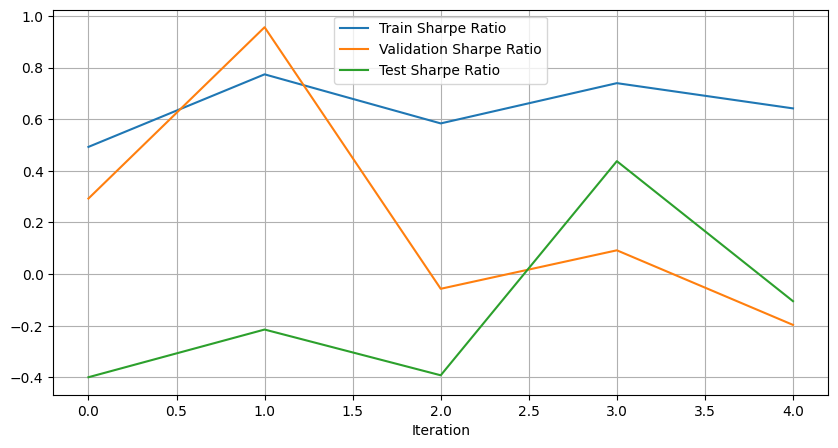

In [25]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.plot(range(5), train_sharpe_list, label='Train Sharpe Ratio')
plt.plot(range(5), val_sharpe_list, label='Validation Sharpe Ratio')
plt.plot(range(5), test_sharpe_list, label='Test Sharpe Ratio')
plt.xlabel('Iteration')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate Fama-French Baseline
ff_results = baseline_fama_french_5(train_dataset, test_dataset)

print("\nFama-French 5-Factor Model Results:")
print(f"  Train Sharpe Ratio: {ff_results['train_sharpe']:.4f}")
print(f"  Test Sharpe Ratio: {ff_results['test_sharpe']:.4f}")
print(f"  Average |Alpha|: {ff_results['avg_alpha']:.6f}")


# Evaluate Mean-Variance Baseline
mv_results = baseline_linear_mv(train_dataset, test_dataset)

print("\nLinear Mean-Variance Portfolio Results:")
print(f"  Train Sharpe Ratio: {mv_results['train_sharpe']:.4f}")
print(f"  Test Sharpe Ratio: {mv_results['test_sharpe']:.4f}")
print(f"  Portfolio weights range: [{mv_results['weights'].min():.4f}, {mv_results['weights'].max():.4f}]")


BASELINE 1: Fama-French 5-Factor Model
Train Sharpe Ratio: 0.2137
Test Sharpe Ratio: -0.4991
Average |Alpha|: 0.011956

Fama-French 5-Factor Model Results:
  Train Sharpe Ratio: 0.2137
  Test Sharpe Ratio: -0.4991
  Average |Alpha|: 0.011956

BASELINE 2: Linear Mean-Variance Portfolio
Train Sharpe Ratio: 0.4009
Test Sharpe Ratio: -0.9752
Portfolio weights range: [-0.1320, 0.1561]

Linear Mean-Variance Portfolio Results:
  Train Sharpe Ratio: 0.4009
  Test Sharpe Ratio: -0.9752
  Portfolio weights range: [-0.1320, 0.1561]


# Hyperparameter Tuning

This section uses the Optuna library to tune the hyperparameters of the Generator and Discriminator networks to maximize the Sharpe Ratio on the validation set.

In [27]:
import optuna

def objective(trial):
  # Define these variables within the objective function for scope
  macro_dim = no_macro_features
  ff_dim = no_of_FF_features
  num_assets = no_of_portfolios


  hidden_dim = trial.suggest_categorical('hidden_dim', [8, 16, 32])
  lstm_layers = trial.suggest_categorical('lstm_layers', [2, 3, 4])
  hidden_layer = trial.suggest_categorical('hidden_layer', [16, 32, 64])
  epochs = trial.suggest_categorical('epochs', [1000, 1500])
  d_lr = trial.suggest_categorical('d_lr', [1e-5, 1e-4])
  g_lr = trial.suggest_categorical('g_lr', [1e-5, 1e-4])

  generator = Generator(macro_dim, ff_dim, hidden_dim, lstm_layers, num_assets)
  discriminator = Discriminator(macro_dim, ff_dim, num_assets, hidden_layer)

  g_losses, d_losses = training(generator, discriminator, train_dataset, epochs, d_lr, g_lr)

  Gan_val = evaluate_GAN(generator, val_dataset)

  return Gan_val['sharpe_ratio']

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_params = study.best_params

[I 2025-11-10 18:22:28,132] A new study created in memory with name: no-name-64828dd5-b9fd-40de-913d-fc569990042b


Epoch [50/1500], G Loss: 0.083751, D Loss: -0.094921
Epoch [100/1500], G Loss: 0.206135, D Loss: -0.191823
Epoch [150/1500], G Loss: 0.226612, D Loss: -0.217086
Epoch [200/1500], G Loss: 0.182570, D Loss: -0.194062
Epoch [250/1500], G Loss: 0.148585, D Loss: -0.129396
Epoch [300/1500], G Loss: 0.085988, D Loss: -0.066030
Epoch [350/1500], G Loss: 0.041009, D Loss: -0.069960
Epoch [400/1500], G Loss: 0.029723, D Loss: -0.017709
Epoch [450/1500], G Loss: 0.014897, D Loss: -0.014624
Epoch [500/1500], G Loss: 0.022052, D Loss: -0.011544
Epoch [550/1500], G Loss: 0.020795, D Loss: -0.010500
Epoch [600/1500], G Loss: 0.021542, D Loss: -0.015152
Epoch [650/1500], G Loss: 0.029692, D Loss: -0.015219
Epoch [700/1500], G Loss: 0.012611, D Loss: -0.007919
Epoch [750/1500], G Loss: 0.029817, D Loss: -0.031290
Epoch [800/1500], G Loss: 0.033441, D Loss: -0.026252
Epoch [850/1500], G Loss: 0.012848, D Loss: -0.014120
Epoch [900/1500], G Loss: 0.012341, D Loss: -0.005273
Epoch [950/1500], G Loss: 0.0

[I 2025-11-10 18:24:15,924] Trial 0 finished with value: 0.7937076128948682 and parameters: {'hidden_dim': 8, 'lstm_layers': 2, 'hidden_layer': 64, 'epochs': 1500, 'd_lr': 1e-05, 'g_lr': 1e-05}. Best is trial 0 with value: 0.7937076128948682.


Epoch [1500/1500], G Loss: 0.024855, D Loss: -0.015138
Epoch [50/1500], G Loss: 0.002863, D Loss: 0.000046
Epoch [100/1500], G Loss: 0.003137, D Loss: 0.000634
Epoch [150/1500], G Loss: 0.002017, D Loss: 0.000282
Epoch [200/1500], G Loss: 0.002154, D Loss: 0.000344
Epoch [250/1500], G Loss: 0.001659, D Loss: 0.000632
Epoch [300/1500], G Loss: 0.001972, D Loss: -0.000256
Epoch [350/1500], G Loss: 0.001774, D Loss: -0.000112
Epoch [400/1500], G Loss: 0.001861, D Loss: 0.000299
Epoch [450/1500], G Loss: 0.001842, D Loss: 0.000390
Epoch [500/1500], G Loss: 0.001451, D Loss: 0.000439
Epoch [550/1500], G Loss: 0.002472, D Loss: -0.000524
Epoch [600/1500], G Loss: 0.001911, D Loss: -0.003576
Epoch [650/1500], G Loss: 0.002386, D Loss: -0.000704
Epoch [700/1500], G Loss: 0.002209, D Loss: -0.000153
Epoch [750/1500], G Loss: 0.004145, D Loss: -0.001090
Epoch [800/1500], G Loss: 0.001163, D Loss: 0.000744
Epoch [850/1500], G Loss: 0.001622, D Loss: -0.000992
Epoch [900/1500], G Loss: 0.002213, D

[I 2025-11-10 18:26:19,393] Trial 1 finished with value: -0.0029098997756742398 and parameters: {'hidden_dim': 16, 'lstm_layers': 3, 'hidden_layer': 32, 'epochs': 1500, 'd_lr': 1e-05, 'g_lr': 0.0001}. Best is trial 0 with value: 0.7937076128948682.


Epoch [1500/1500], G Loss: 0.003110, D Loss: -0.001163
Epoch [50/1000], G Loss: 2.168785, D Loss: -1.490244
Epoch [100/1000], G Loss: 2.106033, D Loss: -2.025744
Epoch [150/1000], G Loss: 1.689812, D Loss: -1.501435
Epoch [200/1000], G Loss: 1.381237, D Loss: -1.494681
Epoch [250/1000], G Loss: 1.397070, D Loss: -1.341044
Epoch [300/1000], G Loss: 1.146589, D Loss: -1.097826
Epoch [350/1000], G Loss: 0.756825, D Loss: -0.674929
Epoch [400/1000], G Loss: 0.810729, D Loss: -0.730438
Epoch [450/1000], G Loss: 0.676012, D Loss: -0.797662
Epoch [500/1000], G Loss: 0.645892, D Loss: -0.542355
Epoch [550/1000], G Loss: 0.307391, D Loss: -0.325051
Epoch [600/1000], G Loss: 0.374775, D Loss: -0.416480
Epoch [650/1000], G Loss: 0.293349, D Loss: -0.312851
Epoch [700/1000], G Loss: 0.283624, D Loss: -0.301592
Epoch [750/1000], G Loss: 0.226850, D Loss: -0.175199
Epoch [800/1000], G Loss: 0.191070, D Loss: -0.153117
Epoch [850/1000], G Loss: 0.213850, D Loss: -0.161645
Epoch [900/1000], G Loss: 0.

[I 2025-11-10 18:27:31,150] Trial 2 finished with value: -0.4388232616181237 and parameters: {'hidden_dim': 8, 'lstm_layers': 2, 'hidden_layer': 64, 'epochs': 1000, 'd_lr': 0.0001, 'g_lr': 1e-05}. Best is trial 0 with value: 0.7937076128948682.


Epoch [1000/1000], G Loss: 0.185650, D Loss: -0.178746
Epoch [50/1500], G Loss: 0.007804, D Loss: -0.004323
Epoch [100/1500], G Loss: 0.005633, D Loss: -0.001481
Epoch [150/1500], G Loss: 0.004455, D Loss: -0.001617
Epoch [200/1500], G Loss: 0.003886, D Loss: -0.002492
Epoch [250/1500], G Loss: 0.005361, D Loss: -0.001963
Epoch [300/1500], G Loss: 0.004611, D Loss: -0.001259
Epoch [350/1500], G Loss: 0.003742, D Loss: -0.001217
Epoch [400/1500], G Loss: 0.004392, D Loss: -0.001259
Epoch [450/1500], G Loss: 0.004914, D Loss: -0.001847
Epoch [500/1500], G Loss: 0.004293, D Loss: -0.001487
Epoch [550/1500], G Loss: 0.004556, D Loss: -0.001996
Epoch [600/1500], G Loss: 0.005068, D Loss: -0.000829
Epoch [650/1500], G Loss: 0.005337, D Loss: -0.003427
Epoch [700/1500], G Loss: 0.005968, D Loss: -0.001903
Epoch [750/1500], G Loss: 0.007447, D Loss: -0.003978
Epoch [800/1500], G Loss: 0.006916, D Loss: -0.003609
Epoch [850/1500], G Loss: 0.006771, D Loss: -0.003165
Epoch [900/1500], G Loss: 0.

[I 2025-11-10 18:29:51,082] Trial 3 finished with value: -0.49191359518822847 and parameters: {'hidden_dim': 8, 'lstm_layers': 4, 'hidden_layer': 32, 'epochs': 1500, 'd_lr': 1e-05, 'g_lr': 0.0001}. Best is trial 0 with value: 0.7937076128948682.


Epoch [1500/1500], G Loss: 0.010140, D Loss: -0.006194
Epoch [50/1500], G Loss: 0.003585, D Loss: -0.000267
Epoch [100/1500], G Loss: 0.003544, D Loss: 0.000018
Epoch [150/1500], G Loss: 0.003953, D Loss: 0.000298
Epoch [200/1500], G Loss: 0.002035, D Loss: -0.000871
Epoch [250/1500], G Loss: 0.002389, D Loss: 0.000567
Epoch [300/1500], G Loss: 0.002111, D Loss: -0.000113
Epoch [350/1500], G Loss: 0.002598, D Loss: -0.000971
Epoch [400/1500], G Loss: 0.002683, D Loss: 0.000223
Epoch [450/1500], G Loss: 0.003856, D Loss: -0.001058
Epoch [500/1500], G Loss: 0.002568, D Loss: 0.000158
Epoch [550/1500], G Loss: 0.002828, D Loss: -0.000741
Epoch [600/1500], G Loss: 0.002572, D Loss: 0.000129
Epoch [650/1500], G Loss: 0.004230, D Loss: -0.000290
Epoch [700/1500], G Loss: 0.003577, D Loss: -0.002144
Epoch [750/1500], G Loss: 0.002697, D Loss: -0.000048
Epoch [800/1500], G Loss: 0.006237, D Loss: -0.002519
Epoch [850/1500], G Loss: 0.004062, D Loss: -0.002518
Epoch [900/1500], G Loss: 0.003460

[I 2025-11-10 18:31:40,072] Trial 4 finished with value: -0.08384236965122958 and parameters: {'hidden_dim': 16, 'lstm_layers': 2, 'hidden_layer': 64, 'epochs': 1500, 'd_lr': 1e-05, 'g_lr': 0.0001}. Best is trial 0 with value: 0.7937076128948682.


Epoch [1500/1500], G Loss: 0.006233, D Loss: -0.000519
Epoch [50/1000], G Loss: 0.009479, D Loss: -0.005361
Epoch [100/1000], G Loss: 0.008102, D Loss: -0.004017
Epoch [150/1000], G Loss: 0.009181, D Loss: -0.009698
Epoch [200/1000], G Loss: 0.018764, D Loss: -0.012310
Epoch [250/1000], G Loss: 0.010354, D Loss: -0.008843
Epoch [300/1000], G Loss: 0.018642, D Loss: -0.024283
Epoch [350/1000], G Loss: 0.027534, D Loss: -0.019583
Epoch [400/1000], G Loss: 0.036105, D Loss: -0.028472
Epoch [450/1000], G Loss: 0.131752, D Loss: -0.029295
Epoch [500/1000], G Loss: 0.020509, D Loss: -0.030694
Epoch [550/1000], G Loss: 0.037475, D Loss: -0.019299
Epoch [600/1000], G Loss: 0.042643, D Loss: -0.037822
Epoch [650/1000], G Loss: 0.036203, D Loss: -0.037621
Epoch [700/1000], G Loss: 0.049264, D Loss: -0.047293
Epoch [750/1000], G Loss: 0.028552, D Loss: -0.042442
Epoch [800/1000], G Loss: 0.029711, D Loss: -0.024291
Epoch [850/1000], G Loss: 0.083524, D Loss: -0.054720
Epoch [900/1000], G Loss: 0.

[I 2025-11-10 18:33:05,852] Trial 5 finished with value: 1.232426810333689 and parameters: {'hidden_dim': 32, 'lstm_layers': 3, 'hidden_layer': 64, 'epochs': 1000, 'd_lr': 1e-05, 'g_lr': 1e-05}. Best is trial 5 with value: 1.232426810333689.


Epoch [1000/1000], G Loss: 0.026434, D Loss: -0.010768
Epoch [50/1000], G Loss: 0.002911, D Loss: 0.000826
Epoch [100/1000], G Loss: 0.002988, D Loss: 0.000123
Epoch [150/1000], G Loss: 0.002676, D Loss: 0.000867
Epoch [200/1000], G Loss: 0.002404, D Loss: 0.000776
Epoch [250/1000], G Loss: 0.002135, D Loss: 0.000863
Epoch [300/1000], G Loss: 0.002754, D Loss: 0.000267
Epoch [350/1000], G Loss: 0.001754, D Loss: 0.000618
Epoch [400/1000], G Loss: 0.001699, D Loss: 0.000746
Epoch [450/1000], G Loss: 0.001622, D Loss: 0.000598
Epoch [500/1000], G Loss: 0.001562, D Loss: 0.000775
Epoch [550/1000], G Loss: 0.004539, D Loss: 0.000037
Epoch [600/1000], G Loss: 0.001792, D Loss: 0.000753
Epoch [650/1000], G Loss: 0.002090, D Loss: 0.000541
Epoch [700/1000], G Loss: 0.001472, D Loss: 0.000337
Epoch [750/1000], G Loss: 0.001621, D Loss: 0.000462
Epoch [800/1000], G Loss: 0.002449, D Loss: 0.000070
Epoch [850/1000], G Loss: 0.001661, D Loss: -0.000104
Epoch [900/1000], G Loss: 0.001647, D Loss: 

[I 2025-11-10 18:34:37,515] Trial 6 finished with value: -0.020605073675247127 and parameters: {'hidden_dim': 8, 'lstm_layers': 4, 'hidden_layer': 16, 'epochs': 1000, 'd_lr': 1e-05, 'g_lr': 0.0001}. Best is trial 5 with value: 1.232426810333689.


Epoch [1000/1000], G Loss: 0.001719, D Loss: -0.000220
Epoch [50/1500], G Loss: 0.003621, D Loss: -0.000177
Epoch [100/1500], G Loss: 0.006937, D Loss: -0.003843
Epoch [150/1500], G Loss: 0.008103, D Loss: -0.004777
Epoch [200/1500], G Loss: 0.007990, D Loss: -0.003376
Epoch [250/1500], G Loss: 0.017432, D Loss: -0.010322
Epoch [300/1500], G Loss: 0.018005, D Loss: -0.012021
Epoch [350/1500], G Loss: 0.016273, D Loss: -0.014178
Epoch [400/1500], G Loss: 0.011983, D Loss: -0.007663
Epoch [450/1500], G Loss: 0.013872, D Loss: -0.008811
Epoch [500/1500], G Loss: 0.011493, D Loss: -0.003797
Epoch [550/1500], G Loss: 0.012475, D Loss: -0.006581
Epoch [600/1500], G Loss: 0.017678, D Loss: -0.009834
Epoch [650/1500], G Loss: 0.007582, D Loss: -0.000514
Epoch [700/1500], G Loss: 0.015371, D Loss: -0.010379
Epoch [750/1500], G Loss: 0.013100, D Loss: -0.006340
Epoch [800/1500], G Loss: 0.026280, D Loss: -0.018724
Epoch [850/1500], G Loss: 0.010469, D Loss: -0.004321
Epoch [900/1500], G Loss: 0.

[I 2025-11-10 18:36:54,904] Trial 7 finished with value: 0.20738594637447158 and parameters: {'hidden_dim': 8, 'lstm_layers': 4, 'hidden_layer': 16, 'epochs': 1500, 'd_lr': 0.0001, 'g_lr': 0.0001}. Best is trial 5 with value: 1.232426810333689.


Epoch [1500/1500], G Loss: 0.005500, D Loss: 0.001025
Epoch [50/1500], G Loss: 1.286345, D Loss: -1.369621
Epoch [100/1500], G Loss: 1.678015, D Loss: -1.274157
Epoch [150/1500], G Loss: 1.186261, D Loss: -1.378110
Epoch [200/1500], G Loss: 0.943164, D Loss: -0.823091
Epoch [250/1500], G Loss: 0.402329, D Loss: -0.646531
Epoch [300/1500], G Loss: 0.456943, D Loss: -0.473037
Epoch [350/1500], G Loss: 0.317845, D Loss: -0.212858
Epoch [400/1500], G Loss: 0.402034, D Loss: -0.300348
Epoch [450/1500], G Loss: 0.285809, D Loss: -0.285749
Epoch [500/1500], G Loss: 0.193501, D Loss: -0.223101
Epoch [550/1500], G Loss: 0.404307, D Loss: -0.253363
Epoch [600/1500], G Loss: 0.228409, D Loss: -0.338637
Epoch [650/1500], G Loss: 0.179360, D Loss: -0.328063
Epoch [700/1500], G Loss: 0.144202, D Loss: -0.171339
Epoch [750/1500], G Loss: 0.203693, D Loss: -0.154685
Epoch [800/1500], G Loss: 0.106623, D Loss: -0.151097
Epoch [850/1500], G Loss: 0.131762, D Loss: -0.161625
Epoch [900/1500], G Loss: 0.1

[I 2025-11-10 18:39:18,914] Trial 8 finished with value: -0.4605982265650508 and parameters: {'hidden_dim': 16, 'lstm_layers': 4, 'hidden_layer': 64, 'epochs': 1500, 'd_lr': 0.0001, 'g_lr': 1e-05}. Best is trial 5 with value: 1.232426810333689.


Epoch [1500/1500], G Loss: 0.135183, D Loss: -0.113993
Epoch [50/1000], G Loss: 0.004430, D Loss: -0.002131
Epoch [100/1000], G Loss: 0.006866, D Loss: -0.000884
Epoch [150/1000], G Loss: 0.007926, D Loss: -0.001504
Epoch [200/1000], G Loss: 0.011755, D Loss: -0.011449
Epoch [250/1000], G Loss: 0.025771, D Loss: -0.019905
Epoch [300/1000], G Loss: 0.020676, D Loss: -0.024340
Epoch [350/1000], G Loss: 0.018461, D Loss: -0.024331
Epoch [400/1000], G Loss: 0.015360, D Loss: -0.010064
Epoch [450/1000], G Loss: 0.016721, D Loss: -0.013352
Epoch [500/1000], G Loss: 0.009510, D Loss: -0.006017
Epoch [550/1000], G Loss: 0.015992, D Loss: -0.012861
Epoch [600/1000], G Loss: 0.011026, D Loss: -0.008487
Epoch [650/1000], G Loss: 0.009011, D Loss: -0.007787
Epoch [700/1000], G Loss: 0.014413, D Loss: -0.008675
Epoch [750/1000], G Loss: 0.010433, D Loss: -0.015284
Epoch [800/1000], G Loss: 0.013912, D Loss: -0.006786
Epoch [850/1000], G Loss: 0.042330, D Loss: -0.022550
Epoch [900/1000], G Loss: 0.

[I 2025-11-10 18:40:38,796] Trial 9 finished with value: 0.3240442658534342 and parameters: {'hidden_dim': 8, 'lstm_layers': 3, 'hidden_layer': 16, 'epochs': 1000, 'd_lr': 1e-05, 'g_lr': 1e-05}. Best is trial 5 with value: 1.232426810333689.


Epoch [1000/1000], G Loss: 0.028906, D Loss: -0.006912


In [29]:
print(best_params)

{'hidden_dim': 32, 'lstm_layers': 3, 'hidden_layer': 64, 'epochs': 1000, 'd_lr': 1e-05, 'g_lr': 1e-05}


Financial data has high noise to signal ratio and the model is sensitive to the initial values so we choose the top 3 best hyperparameter combinations:


1.  **Trial 5:** Validation Sharpe Ratio: 1.2324
    *   `hidden_dim`: 32
    *   `lstm_layers`: 3
    *   `hidden_layer`: 64
    *   `epochs`: 1000
    *   `d_lr`: 1e-05
    *   `g_lr`: 1e-05

2.  **Trial 0:** Validation Sharpe Ratio: 0.7937
    *   `hidden_dim`: 8
    *   `lstm_layers`: 2
    *   `hidden_layer`: 64
    *   `epochs`: 1500
    *   `d_lr`: 1e-05
    *   `g_lr`: 1e-05

3.  **Trial 9:** Validation Sharpe Ratio: 0.3240
    *   `hidden_dim`: 8
    *   `lstm_layers`: 3
    *   `hidden_layer`: 16
    *   `epochs`: 1000
    *   `d_lr`: 1e-05
    *   `g_lr`: 1e-05

Retraining the model on these hyperparameters. We set the epochs to 1500 on all 3 of them


In [30]:
import matplotlib.pyplot as plt
import numpy as np

top_hyperparameters = [
    {'hidden_dim': 32, 'lstm_layers': 3, 'hidden_layer': 64, 'epochs': 1500, 'd_lr': 1e-05, 'g_lr': 1e-05}, # Trial 5
    {'hidden_dim': 8, 'lstm_layers': 2, 'hidden_layer': 64, 'epochs': 1500, 'd_lr': 1e-05, 'g_lr': 1e-05}, # Trial 0
    {'hidden_dim': 8, 'lstm_layers': 3, 'hidden_layer': 16, 'epochs': 1500, 'd_lr': 1e-05, 'g_lr': 1e-05}  # Trial 9
]

macro_dim = no_macro_features
ff_dim = no_of_FF_features
num_assets = no_of_portfolios

num_rounds = 30 # Number of training rounds for each hyperparameter combination

all_train_sharpes = []
all_val_sharpes = []
all_test_sharpes = []


for i, params in enumerate(top_hyperparameters):
    print(f"Training with Hyperparameter Set {i+1}: {params}")

    round_train_sharpes = []
    round_val_sharpes = []
    round_test_sharpes = []


    for round_num in range(num_rounds):
        print(f"  Round {round_num + 1}/{num_rounds}")

        generator = Generator(macro_dim, ff_dim, params['hidden_dim'], params['lstm_layers'], num_assets)
        discriminator =  Discriminator(macro_dim, ff_dim, num_assets, params['hidden_layer'])

        # Train the model with the current hyperparameters and get losses
        g_losses, d_losses = training(
            generator,
            discriminator,
            train_dataset,
            params['epochs'],
            params['d_lr'],
            params['g_lr']
        )

        # Evaluate the trained model
        gan_train_result = evaluate_GAN(generator, train_dataset)
        gan_val_result = evaluate_GAN(generator, val_dataset)
        gan_test_result = evaluate_GAN(generator, test_dataset)

        round_train_sharpes.append(gan_train_result['sharpe_ratio'])
        round_val_sharpes.append(gan_val_result['sharpe_ratio'])
        round_test_sharpes.append(gan_test_result['sharpe_ratio'])

    all_train_sharpes.append(round_train_sharpes)
    all_val_sharpes.append(round_val_sharpes)
    all_test_sharpes.append(round_test_sharpes)


# Calculate average Sharpe Ratios across rounds for each hyperparameter set
avg_train_sharpes = np.mean(all_train_sharpes, axis=1)
avg_val_sharpes = np.mean(all_val_sharpes, axis=1)
avg_test_sharpes = np.mean(all_test_sharpes, axis=1)



Training with Hyperparameter Set 1: {'hidden_dim': 32, 'lstm_layers': 3, 'hidden_layer': 64, 'epochs': 1500, 'd_lr': 1e-05, 'g_lr': 1e-05}
  Round 1/30
Epoch [50/1500], G Loss: 0.017367, D Loss: -0.025713
Epoch [100/1500], G Loss: 0.046371, D Loss: -0.024828
Epoch [150/1500], G Loss: 0.044934, D Loss: -0.025844
Epoch [200/1500], G Loss: 0.047876, D Loss: -0.036950
Epoch [250/1500], G Loss: 0.027542, D Loss: -0.038772
Epoch [300/1500], G Loss: 0.039588, D Loss: -0.059671
Epoch [350/1500], G Loss: 0.044363, D Loss: -0.033662
Epoch [400/1500], G Loss: 0.043862, D Loss: -0.039128
Epoch [450/1500], G Loss: 0.027612, D Loss: -0.034552
Epoch [500/1500], G Loss: 0.025940, D Loss: -0.031100
Epoch [550/1500], G Loss: 0.037218, D Loss: -0.049027
Epoch [600/1500], G Loss: 0.043475, D Loss: -0.057795
Epoch [650/1500], G Loss: 0.030194, D Loss: -0.068001
Epoch [700/1500], G Loss: 0.019330, D Loss: -0.026078
Epoch [750/1500], G Loss: 0.030162, D Loss: -0.027574
Epoch [800/1500], G Loss: 0.025584, D L

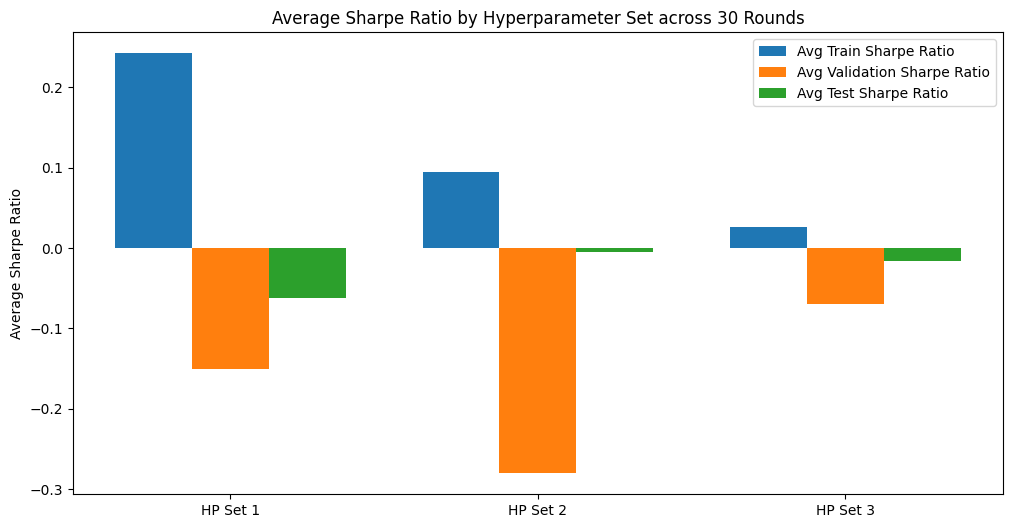


Average Sharpe Ratios across 30 Rounds:
Hyperparameter Set 1:
  Avg Train Sharpe Ratio: 0.2424
  Avg Validation Sharpe Ratio: -0.1506
  Avg Test Sharpe Ratio: -0.0625
Hyperparameter Set 2:
  Avg Train Sharpe Ratio: 0.0949
  Avg Validation Sharpe Ratio: -0.2802
  Avg Test Sharpe Ratio: -0.0055
Hyperparameter Set 3:
  Avg Train Sharpe Ratio: 0.0265
  Avg Validation Sharpe Ratio: -0.0699
  Avg Test Sharpe Ratio: -0.0161


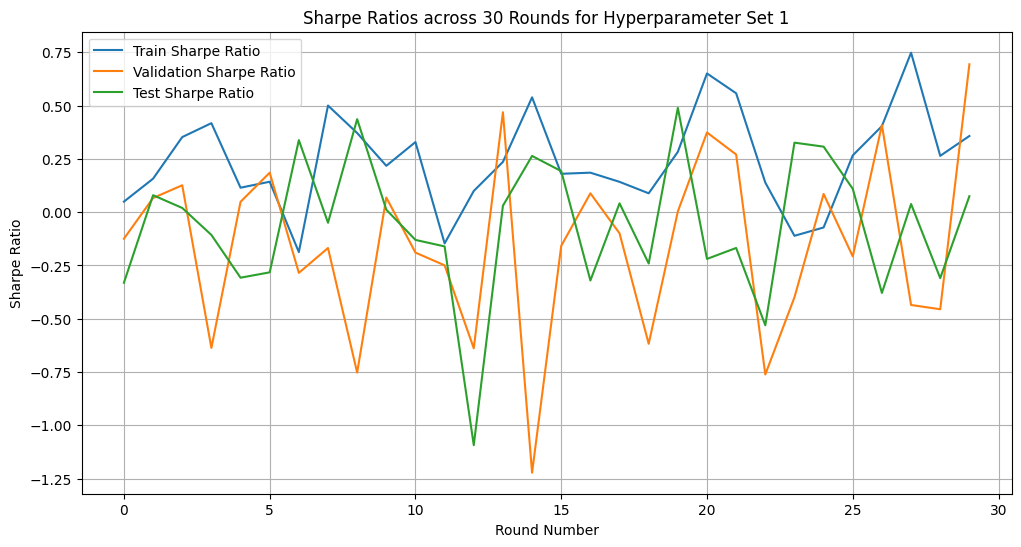

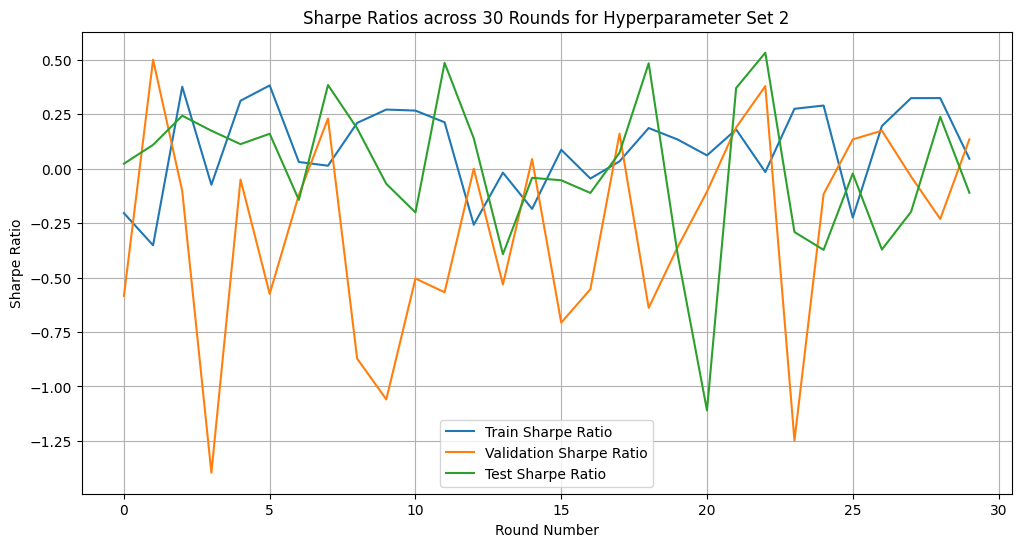

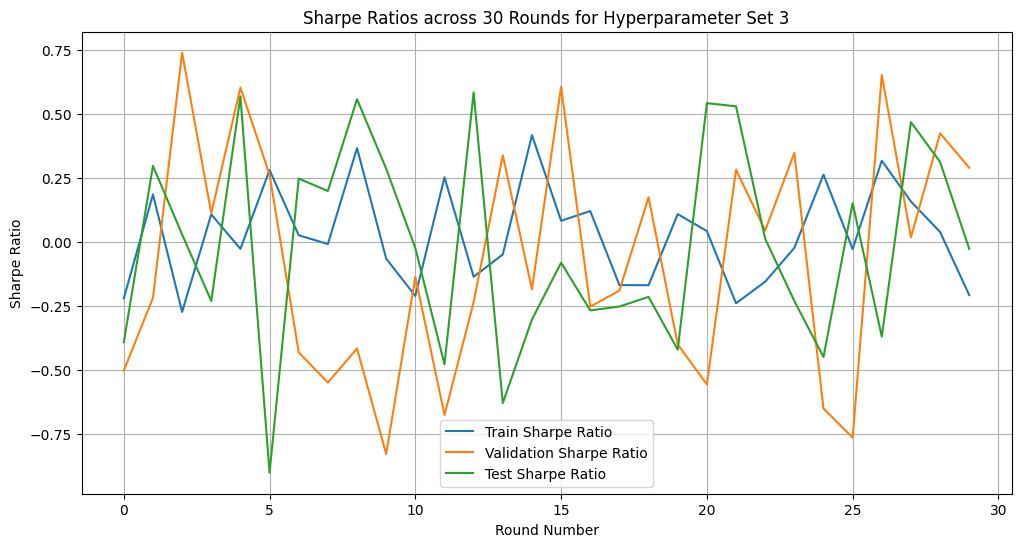

In [33]:
# Plot the average Sharpe Ratios for each hyperparameter set
labels = [f'HP Set {i+1}' for i in range(len(top_hyperparameters))]
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, avg_train_sharpes, width, label='Avg Train Sharpe Ratio')
rects2 = ax.bar(x, avg_val_sharpes, width, label='Avg Validation Sharpe Ratio')
rects3 = ax.bar(x + width, avg_test_sharpes, width, label='Avg Test Sharpe Ratio')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Average Sharpe Ratio')
ax.set_title('Average Sharpe Ratio by Hyperparameter Set across 30 Rounds')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

# Print the average Sharpe Ratios
print("\nAverage Sharpe Ratios across 30 Rounds:")
for i in range(len(top_hyperparameters)):
    print(f"Hyperparameter Set {i+1}:")
    print(f"  Avg Train Sharpe Ratio: {avg_train_sharpes[i]:.4f}")
    print(f"  Avg Validation Sharpe Ratio: {avg_val_sharpes[i]:.4f}")
    print(f"  Avg Test Sharpe Ratio: {avg_test_sharpes[i]:.4f}")


# Plotting Sharpe Ratios for each round for each hyperparameter set
for i, params in enumerate(top_hyperparameters):
    plt.figure(figsize=(12, 6))
    plt.plot(range(num_rounds), all_train_sharpes[i], label='Train Sharpe Ratio')
    plt.plot(range(num_rounds), all_val_sharpes[i], label='Validation Sharpe Ratio')
    plt.plot(range(num_rounds), all_test_sharpes[i], label='Test Sharpe Ratio')
    plt.xlabel('Round Number')
    plt.ylabel('Sharpe Ratio')
    plt.title(f'Sharpe Ratios across 30 Rounds for Hyperparameter Set {i+1}')
    plt.legend()
    plt.grid(True)
    plt.show()